In [25]:
from pathlib import Path
from pprint import pprint
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.dpi'] = 100


def show_dots(index: int, delta_d: float, diameter: float) -> None:
    """立体視を描画する関数"""
    
    base_x1, base_x2 = 300, 700
    up_y, down_y = 700, 300
    
    xs = [base_x1-delta_d, base_x2+delta_d] + [base_x1, base_x2]    # 上段 + 下段
    ys = [up_y, up_y] + [down_y, down_y]
        
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))

    plt.scatter(xs, ys, c="k", s=diameter)
    plt.title(f"{delta_d = }, {diameter = }")
    plt.xlim(0,1000)
    plt.ylim(0,1000)

    ax.axis("off")

    plt.savefig(f'images/frame_{diameter}_{index}.png')
    plt.show()

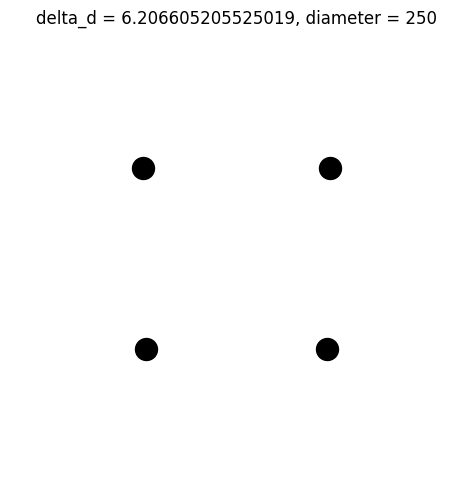

In [26]:
Path("images").mkdir(exist_ok=True)

# 実験
results = []
for diameter in range(50, 300, 50):
    for index in range(20):
        delta_d = random.uniform(-10, 10)
        show_dots(index, delta_d, diameter)
        
        instr = input("奥行きが異なる(1) or 奥行きが等しい(0): ")
        if instr == "exit":
            break
        
        results.append({
            "delta_d": delta_d,
            "diameter": diameter,
            "recognizable": (1 == int(instr))
            })
        
        clear_output(True)

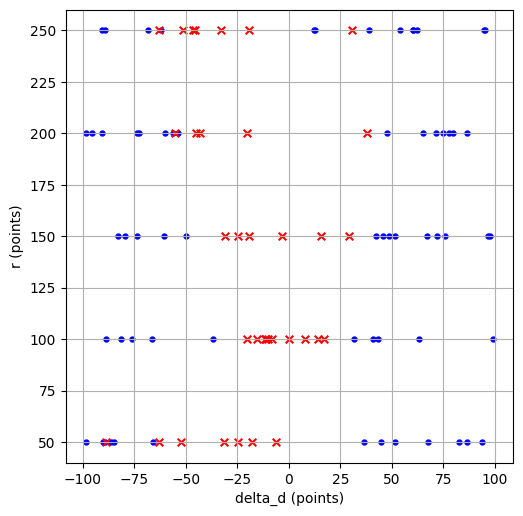

In [31]:
# 実験結果の表示
delta_ds_ok = []
delta_ds_ng = []
diameters_ok = []
diameters_ng = []
for result in results:
    if result["recognizable"]:
        delta_ds_ok.append(result["delta_d"]*10)    # 軸のスケールを統一するために10倍する
        diameters_ok.append(result["diameter"])
    else:
        delta_ds_ng.append(result["delta_d"]*10)
        diameters_ng.append(result["diameter"])
        

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))

plt.scatter(delta_ds_ok, diameters_ok, marker=".", c="b", s=50)
plt.scatter(delta_ds_ng, diameters_ng, marker="x", c="r", s=30)
plt.xlabel("delta_d (points)", fontsize=10)
plt.ylabel("r (points)", fontsize=10)
plt.grid(True)

plt.savefig(f'images/result.png')
plt.show()